In [129]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import pandas as pd 
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Silhouette
from gtda.diagrams import BettiCurve, PersistenceLandscape
from ripser import ripser
from persim import plot_diagrams
from persim import bottleneck, bottleneck_matching, wasserstein, wasserstein_matching
from gtda.time_series import Resampler
import plotly.express as px
import math

Let's look at the experimental data from Imperial College, campaign 22, where they recreate severe slugging events and measure the liquid holdup as a function of time. 

In [30]:
C22F002 = pd.read_csv('C22F002.csv')

In [247]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    inv = np.fft.fft(ft)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw, inv

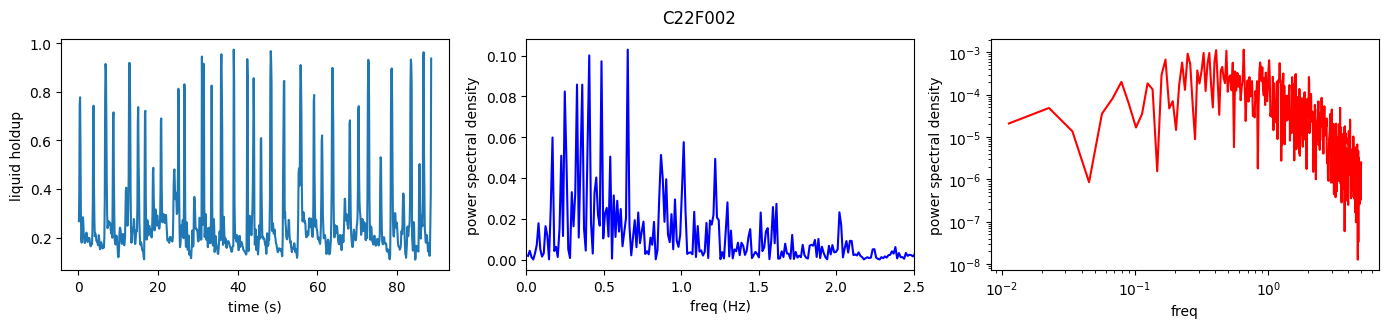

In [248]:
fig_C22F002, data = plt.subplots(1, 3, figsize=(17, 3))

fig_C22F002.suptitle('C22F002')
data[0].set_xlabel('time (s)')
data[0].set_ylabel('liquid holdup')
data[1].set_xlabel('freq (Hz)')
data[1].set_ylabel('power spectral density')
data[1].set_xlim([0,2.5])
data[2].set_xlabel('freq')
data[2].set_ylabel('power spectral density')

freqs, ps, psd, inv = spectrum1(C22F002[C22F002.columns[1]], dt=0.1)

data[0].plot(C22F002[C22F002.columns[0]],C22F002[C22F002.columns[1]])
#data[1].loglog(freqs,psd,'r',freqs,ps,'b')
data[1].plot(freqs,psd,'b')
data[2].loglog(freqs,ps,'r')



The timeseries has clearly some (semi) periodic component every 3 to 4 seconds (<1 Hz), and other components occuring right after the main peaks with higher frequency.

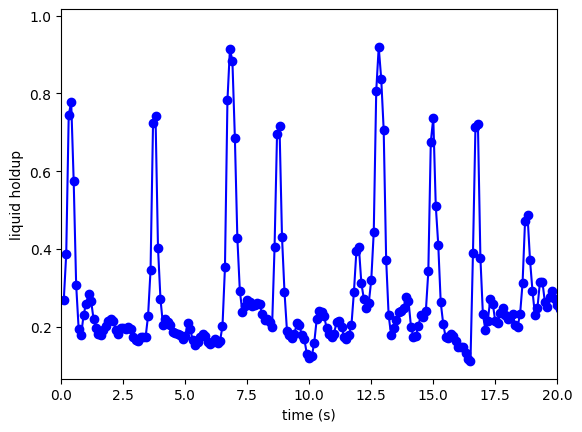

In [142]:
plt.xlim([0,20])
plt.xlabel('time (s)');
plt.ylabel('liquid holdup');
plt.plot(C22F002[C22F002.columns[0]],C22F002[C22F002.columns[1]], 'bo-')

In [65]:
slug_signal = C22F002.iloc[:, 1]

In [127]:
def TDAanalyze(signal, stride):
    # a function to extract persistence entropy directly, for optimal embedding parameters only
    max_time_delay = int(len(signal)/2) 
    max_embedding_dimension = int(len(signal)/20)
    print('length of signal to analyze', len(signal))
    print('max time delay', max_time_delay)
    print('max dim embedding', max_embedding_dimension)
    print('stride', stride)

    optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        signal, max_time_delay, max_embedding_dimension, stride=stride
        )

    print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
    print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
    
    embedding_dimension = optimal_embedding_dimension
    embedding_time_delay = optimal_time_delay
    stride = stride

    embedder = SingleTakensEmbedding(
        parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
        )

    y_signal_embedded = embedder.fit_transform(signal)

    pca = PCA(n_components=3)
    y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

    plot_point_cloud(y_signal_embedded_pca)
    
    homology_dimensions = (0, 1, 2)
    VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

    y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)
 
    PH_signal = VRP.fit_transform(y_signal_embedded_reshaped)
    VRP.plot(PH_signal)
    PE_signal = PersistenceEntropy()
    features = PE_signal.fit_transform(PH_signal)

    return features


def MaxPers(PH):
    # function that comptues the highest persistence (per homology class) 
    # in a presistence diagram
    arrH0 = []
    arrH2 = []
    arrH1 = []
    dist_H0 = []
    dist_H1 = []
    dist_H2 = []
    for triplet in PH:
        for i in range(len(triplet)):
            if triplet[i][2] == 0: arrH0.append(triplet[i][:2])
            if triplet[i][2] == 1: arrH1.append(triplet[i][:2])
            if triplet[i][2] == 2: arrH2.append(triplet[i][:2])
    
    for x in arrH0:
        dist = x[1]
        dist_H0.append(dist)
    for x in arrH1:
        dist = np.linalg.norm(x - [(x[0]+x[1])/2,(x[0]+x[1])/2])
        dist_H1.append(dist)
    for x in arrH2:
        dist = np.linalg.norm(x - [(x[0]+x[1])/2,(x[0]+x[1])/2])
        dist_H2.append(dist)
        
    print('Max persistence class H_0:', max(dist_H0), 'at point:', arrH0[dist_H0.index(max(dist_H0))] )
    print('Max persistence class H_1:', max(dist_H1), 'at point:', arrH1[dist_H1.index(max(dist_H1))] ) 
    print('Max persistence class H_2:', max(dist_H2), 'at point:', arrH2[dist_H2.index(max(dist_H2))] )
   
    return 

def TDAConvergenceDim(signal, stride):
    # a function that loops over the embedding dimensions 
    max_time_delay = int(len(signal)/2) 
    max_embedding_dimension = int(len(signal)/20)
    print('length of signal to analyze', len(signal))
    print('max time delay', max_time_delay)
    print('max dim embedding', max_embedding_dimension)
    print('stride', stride)

    optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        signal, max_time_delay, max_embedding_dimension, stride=stride
        )

    print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
    print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
    
    ndim_max = optimal_embedding_dimension + 2
    features_list = []
    
    ndim = 3
    
    while ndim <= ndim_max:
    
        embedding_dimension = ndim
        embedding_time_delay = optimal_time_delay
        stride = stride

        embedder = SingleTakensEmbedding(
            parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
            )

        y_signal_embedded = embedder.fit_transform(signal)

        pca = PCA(n_components=3)
        y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

        plot_point_cloud(y_signal_embedded_pca)

        homology_dimensions = (0, 1, 2)
        VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

    # the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

        y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)

        PH_signal = VRP.fit_transform(y_signal_embedded_reshaped)
        VRP.plot(PH_signal)
        PE_signal = PersistenceEntropy()
        features = PE_signal.fit_transform(PH_signal)
        
        features_to_append = ['dim', ndim, 'entropy', features]
        
        features_list.append(features_to_append)
        ndim += 1
        
    return features_list

def TDAConvergenceDelay(signal, stride):
    # a function that loops over embedding time delays
    max_time_delay = int(len(signal)/2) 
    max_embedding_dimension = int(len(signal)/20)
    print('length of signal to analyze', len(signal))
    print('max time delay', max_time_delay)
    print('max dim embedding', max_embedding_dimension)
    print('stride', stride)

    optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        signal, max_time_delay, max_embedding_dimension, stride=stride
        )

    print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
    print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
    
    delay_max = optimal_time_delay + 4
    
    features_list = []
    
    delay = 1
    
    while delay <= delay_max:
    
        embedding_dimension = optimal_embedding_dimension
        embedding_time_delay = delay
        stride = stride

        embedder = SingleTakensEmbedding(
            parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
            )

        y_signal_embedded = embedder.fit_transform(signal)

        pca = PCA(n_components=3)
        y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

        plot_point_cloud(y_signal_embedded_pca)

        homology_dimensions = (0, 1, 2)
        VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

    # the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

        y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)

        PH_signal = VRP.fit_transform(y_signal_embedded_reshaped)
        VRP.plot(PH_signal)
        PE_signal = PersistenceEntropy()
        features = PE_signal.fit_transform(PH_signal)
        
        features_to_append = ['delay', delay, 'entropy', features]
        
        features_list.append(features_to_append)
        delay += 1
        
    return features_list




In [117]:
from sklearn.metrics import mutual_info_score


def mutual_information(X, time_delay, n_bins):
    """Calculate the mutual information given the time delay."""
    contingency = np.histogram2d(X[:-time_delay], X[time_delay:],
                                 bins=n_bins)[0]
    mutual_information = mutual_info_score(None, None,
                                           contingency=contingency)
    return mutual_information


def plot_optimal_delay(X):
    max_time_delay = int(len(X)/20)
    bins = int(len(X)/100)
    mutual_information_list = []

    for time_delay in range(1, max_time_delay + 1):
        mutual_information_list.append(mutual_information(X, time_delay, n_bins=bins))
           
    plt.plot(range(1,max_time_delay+1),mutual_information_list);
    plt.xlabel('delay');
    plt.ylabel('mutual information');


Let's start the analysis of the time series by establishing the optimal parameters for the embedding.

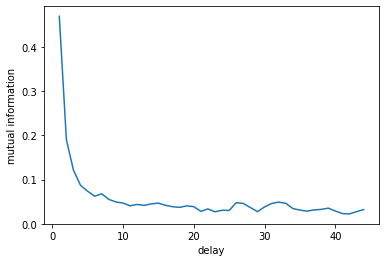

In [118]:
plot_optimal_delay(slug_signal)

In [638]:
TDAConvergenceDim(slug_signal,1)

length of signal to analyze 886
max time delay 443
max dim embedding 44
stride 1
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 8


[['dim', 3, 'entropy', array([[9.40870393, 7.5983497 , 5.25973482]])],
 ['dim', 4, 'entropy', array([[9.40870393, 7.5983497 , 5.25973482]])],
 ['dim', 5, 'entropy', array([[9.51046202, 8.12844252, 6.57675768]])],
 ['dim', 6, 'entropy', array([[9.51046202, 8.12844252, 6.57675768]])],
 ['dim', 7, 'entropy', array([[9.51046202, 8.12844252, 6.57675768]])],
 ['dim', 8, 'entropy', array([[9.5207678 , 8.02061376, 6.37559213]])],
 ['dim', 9, 'entropy', array([[9.5207678 , 8.02061376, 6.37559213]])],
 ['dim', 10, 'entropy', array([[9.5207678 , 8.02061376, 6.37559213]])]]

In [639]:
TDAConvergenceDelay(slug_signal,1)

length of signal to analyze 886
max time delay 443
max dim embedding 44
stride 1
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 8


[['delay', 1, 'entropy', array([[9.32509591, 7.58296077, 6.06933398]])],
 ['delay', 2, 'entropy', array([[9.30548434, 7.627541  , 5.67595621]])],
 ['delay', 3, 'entropy', array([[9.61716706, 7.7435745 , 5.56283928]])],
 ['delay', 4, 'entropy', array([[9.48601452, 7.81625356, 5.62481308]])],
 ['delay', 5, 'entropy', array([[9.56614713, 8.00354027, 5.95416828]])],
 ['delay', 6, 'entropy', array([[9.57707587, 8.06134154, 6.184513  ]])],
 ['delay', 7, 'entropy', array([[9.57707587, 8.06134154, 6.184513  ]])],
 ['delay', 8, 'entropy', array([[9.54463207, 8.1688365 , 6.34346672]])],
 ['delay', 9, 'entropy', array([[9.59371687, 8.20251742, 6.33321024]])],
 ['delay', 10, 'entropy', array([[9.59371687, 8.20251742, 6.33321024]])],
 ['delay', 11, 'entropy', array([[9.5207678 , 8.02061376, 6.37559213]])],
 ['delay', 12, 'entropy', array([[9.5207678 , 8.02061376, 6.37559213]])],
 ['delay', 13, 'entropy', array([[9.5207678 , 8.02061376, 6.37559213]])],
 ['delay', 14, 'entropy', array([[9.5207678 , 8

In [640]:
print('length of signal to analyze', len(slug_signal))

max_time_delay = 15
max_embedding_dimension = 12
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    slug_signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

length of signal to analyze 886
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 8


In [122]:
embedding_dimension = 8
embedding_time_delay = 11
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [54]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 809, 8)
y_slug_embedded.shape (809, 8)


In [55]:
MaxPers(PH_slug)

Max persistence class H_0: 0.533787727355957 at point: [0.         0.53378773]
Max persistence class H_1: 0.14605423476337856 at point: [0.34584936 0.55240124]
Max persistence class H_2: 0.021223614550115587 at point: [0.22616991 0.25618464]


In [56]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[9.5207678 , 8.02061376, 6.37559213]])

The embedding for the parameters suggested from the heuristics, looks very much random. There is no evident loop, circle or torus, but the max persistence and the persistent entropies for the various homology classes are quite high. Just to double check, I perform the ebmedding and the analysis again for a delay=1. 

In [63]:
embedding_dimension = 8
embedding_time_delay = 1
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [58]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 879, 8)
y_slug_embedded.shape (879, 8)


In [59]:
MaxPers(PH_slug)

Max persistence class H_0: 0.8056430220603943 at point: [0.         0.80564302]
Max persistence class H_1: 0.09822330421162344 at point: [0.22006498 0.35897371]
Max persistence class H_2: 0.015361451537583847 at point: [0.47014627 0.49187064]


In [60]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[9.32509591, 7.58296077, 6.06933398]])

In [645]:
SLH = Silhouette()
slug_SLH = SLH.fit_transform_plot(PH_slug)
slug_SLH

array([[[0.00000000e+00, 5.39179523e-03, 1.07835905e-02, 1.61753857e-02,
         2.15607054e-02, 2.69016352e-02, 3.21120626e-02, 3.70064119e-02,
         4.15372567e-02, 4.56251339e-02, 4.91915226e-02, 5.23018268e-02,
         5.47536828e-02, 5.64370897e-02, 5.73811030e-02, 5.76389630e-02,
         5.73239030e-02, 5.65789680e-02, 5.53153646e-02, 5.37436711e-02,
         5.18671310e-02, 4.97126343e-02, 4.73262583e-02, 4.47858505e-02,
         4.22494852e-02, 3.97785983e-02, 3.74202663e-02, 3.50882713e-02,
         3.27897834e-02, 3.05864551e-02, 2.84843712e-02, 2.64801440e-02,
         2.45650323e-02, 2.27090976e-02, 2.10129842e-02, 1.94657704e-02,
         1.79776602e-02, 1.65707973e-02, 1.52463497e-02, 1.40377854e-02,
         1.29293593e-02, 1.19099837e-02, 1.09954564e-02, 1.01780892e-02,
         9.42904188e-03, 8.76934030e-03, 8.18750185e-03, 7.67336517e-03,
         7.13733653e-03, 6.62830508e-03, 6.13396849e-03, 5.64072166e-03,
         5.16995475e-03, 4.77076700e-03, 4.39596729

In [646]:
Betti = BettiCurve()
Betti_wn = Betti.fit_transform_plot(PH_slug)

In [648]:
PLand = PersistenceLandscape()
Slug_PLand = PLand.fit_transform_plot(PH_slug)
Slug_PLand

array([[[0.00000000e+00, 5.39179523e-03, 1.07835905e-02, 1.61753857e-02,
         2.15671809e-02, 2.69589761e-02, 3.23507714e-02, 3.77425666e-02,
         4.31343618e-02, 4.85261570e-02, 5.39179523e-02, 5.93097475e-02,
         6.47015427e-02, 7.00933379e-02, 7.54851332e-02, 8.08769284e-02,
         8.62687236e-02, 9.16605188e-02, 9.70523141e-02, 1.02444109e-01,
         1.07835905e-01, 1.13227700e-01, 1.18619495e-01, 1.24011290e-01,
         1.29403085e-01, 1.34794881e-01, 1.40186676e-01, 1.45578471e-01,
         1.50970266e-01, 1.56362062e-01, 1.61753857e-01, 1.67145652e-01,
         1.72537447e-01, 1.77929242e-01, 1.83321038e-01, 1.88712833e-01,
         1.94104628e-01, 1.99496423e-01, 2.04888219e-01, 2.10280014e-01,
         2.15671809e-01, 2.21063604e-01, 2.26455399e-01, 2.31847195e-01,
         2.37238990e-01, 2.42630785e-01, 2.48022580e-01, 2.53414376e-01,
         2.58806171e-01, 2.64197966e-01, 2.64197966e-01, 2.58806171e-01,
         2.53414376e-01, 2.48022580e-01, 2.42630785

Do the same again, but with stride = 2

In [459]:
embedding_dimension = 8
embedding_time_delay = 11
stride = 2

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [460]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 432, 3)
y_slug_embedded.shape (432, 3)


In [461]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[8.37487246, 6.48645874, 3.72394654]])

In [462]:
SLH = Silhouette()
slug_SLH = SLH.fit_transform_plot(PH_slug)
slug_SLH

array([[[0.00000000e+00, 2.97823350e-03, 5.91937955e-03, 8.59077841e-03,
         1.06937632e-02, 1.22216363e-02, 1.34283803e-02, 1.43528671e-02,
         1.49843014e-02, 1.54306221e-02, 1.56487337e-02, 1.56623079e-02,
         1.55124317e-02, 1.52341642e-02, 1.48313952e-02, 1.43622591e-02,
         1.39065864e-02, 1.34076666e-02, 1.28729929e-02, 1.23620898e-02,
         1.19011724e-02, 1.14318800e-02, 1.10090482e-02, 1.06070788e-02,
         1.01791962e-02, 9.79285077e-03, 9.46062394e-03, 9.19598354e-03,
         8.92347541e-03, 8.71091904e-03, 8.51154929e-03, 8.30010846e-03,
         8.08269863e-03, 7.90025308e-03, 7.71571183e-03, 7.51853434e-03,
         7.33613249e-03, 7.17794922e-03, 7.04138260e-03, 6.91622060e-03,
         6.79105859e-03, 6.68407497e-03, 6.51147852e-03, 6.33888206e-03,
         6.16628561e-03, 5.99368915e-03, 5.85805025e-03, 5.75995399e-03,
         5.66568939e-03, 5.57142479e-03, 5.42043961e-03, 5.21273383e-03,
         5.00502806e-03, 4.79732229e-03, 4.59624104

In [463]:
Betti = BettiCurve()
Betti_wn = Betti.fit_transform_plot(PH_slug)

In [17]:
TDAanalyze(slug_signal, 1)

length of signal to analyze 886
max time delay 443
max dim embedding 44
stride 1
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 8


array([[9.5207678 , 8.02061376, 6.37559213]])

In [18]:
TDAanalyze(slug_signal, 2)

length of signal to analyze 886
max time delay 443
max dim embedding 44
stride 2
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 10


array([[8.48456645, 6.72659428, 4.76899454]])

Albeit there is very low persistence in this timeseries, the homology class H_2 has extremely low entropy. This is sign of order in the high dimensional structure.

In [19]:
C22F002_downsampled_2 = C22F002.iloc[::2, :]
C22F002_downsampled_2

time(s)   liquid holdup 
0        0.1         0.267684
2        0.3         0.744619
4        0.5         0.575393
6        0.7         0.195540
8        0.9         0.230115
..       ...              ...
876     87.7         0.173447
878     87.9         0.154947
880     88.1         0.163688
882     88.3         0.152851
884     88.5         0.376441

[443 rows x 2 columns]

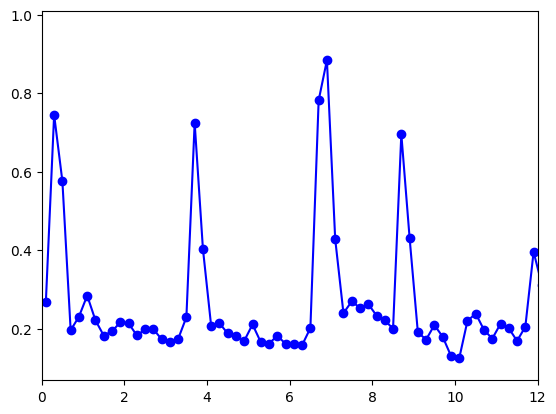

In [20]:
plt.xlim([0,12])
plt.plot(C22F002_downsampled_2[C22F002_downsampled_2.columns[0]],C22F002_downsampled_2[C22F002_downsampled_2.columns[1]], 'bo-')

In [21]:
slug_signal_down = C22F002_downsampled_2.iloc[:, 1]
slug_signal_down.size
TDAanalyze(slug_signal_down, 2)

length of signal to analyze 443
max time delay 221
max dim embedding 22
stride 2
Optimal embedding time delay based on mutual information: 8
Optimal embedding dimension based on false nearest neighbors: 9


array([[7.37728829, 6.05979254, 4.75273863]])

length of signal to analyze 296
max time delay 148
max dim embedding 14
stride 1
Optimal embedding time delay based on mutual information: 5
Optimal embedding dimension based on false nearest neighbors: 8


array([[7.84817101, 6.05865544, 3.52692519]])

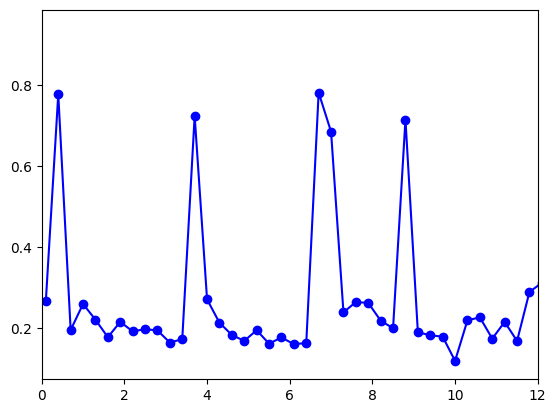

In [22]:
C22F002_downsampled_3 = C22F002.iloc[::3, :]
slug_signal_down = C22F002_downsampled_3.iloc[:, 1]
plt.xlim([0,12])
plt.plot(C22F002_downsampled_3[C22F002_downsampled_3.columns[0]],C22F002_downsampled_3[C22F002_downsampled_3.columns[1]], 'bo-')
TDAanalyze(slug_signal_down, 1)

In [23]:
embedding_dimension = 5
embedding_time_delay = 8
stride = 2

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal_down)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [24]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 143, 3)
y_slug_embedded.shape (143, 3)


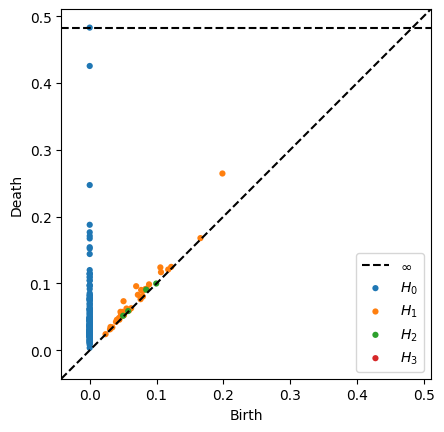

In [25]:
dgms = ripser(y_slug_embedded, maxdim=3)['dgms']
plot_diagrams(dgms, show=True)

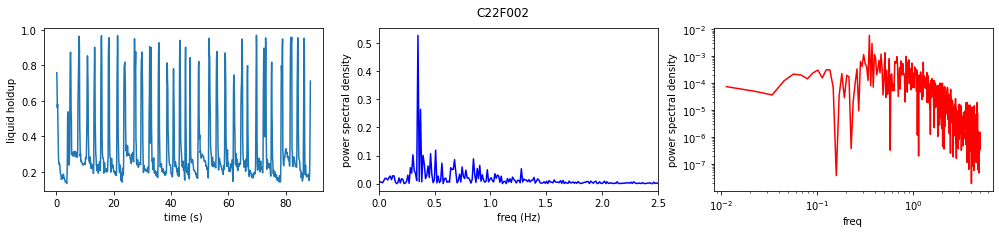

In [123]:
C22F046 = pd.read_csv('C22F046.csv')

fig_C22F046, data = plt.subplots(1, 3, figsize=(17, 3))

fig_C22F046.suptitle('C22F002')
data[0].set_xlabel('time (s)')
data[0].set_ylabel('liquid holdup')
data[1].set_xlabel('freq (Hz)')
data[1].set_ylabel('power spectral density')
data[1].set_xlim([0,2.5])
data[2].set_xlabel('freq')
data[2].set_ylabel('power spectral density')

freqs, ps, psd, inv = spectrum1(C22F046[C22F046.columns[1]], dt=0.1)

data[0].plot(C22F046[C22F046.columns[0]],C22F046[C22F046.columns[1]])
#data[1].loglog(freqs,psd,'r',freqs,ps,'b')
data[1].plot(freqs,psd,'b')
data[2].loglog(freqs,ps,'r')

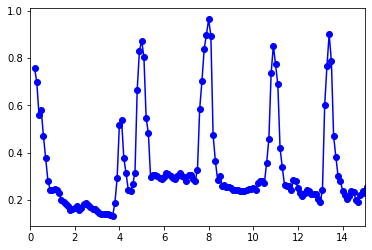

In [124]:
plt.xlim([0,15])
plt.plot(C22F046[C22F046.columns[0]],C22F046[C22F046.columns[1]], 'bo-')

In [125]:
fig = px.line(title='C22F002 vs C22F046')
fig.add_scatter(x=C22F046.iloc[:, 0], y=C22F046.iloc[:, 1], name='C22F046', mode='lines+markers')
fig.add_scatter(x=C22F002.iloc[:, 0], y=C22F002.iloc[:, 1], name='C22F002', mode='lines+markers')
fig.show()

In [130]:
C22F046_signal = C22F046.iloc[:, 1]
TDAanalyze(C22F046_signal, 1)

length of signal to analyze 885
max time delay 442
max dim embedding 44
stride 1
Optimal embedding time delay based on mutual information: 10
Optimal embedding dimension based on false nearest neighbors: 12


array([[9.51424081, 7.8009685 , 6.0110168 ]])

In [135]:
embedding_dimension = 12
embedding_time_delay = 10
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(C22F046_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

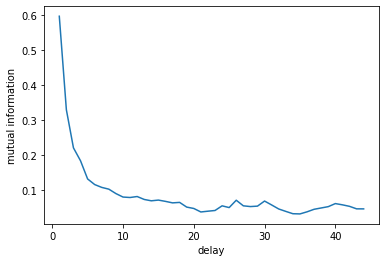

In [132]:
plot_optimal_delay(C22F046_signal)

In [117]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 775, 12)
y_slug_embedded.shape (775, 12)


In [118]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[9.51424081, 7.8009685 , 6.0110168 ]])

In [41]:
embedding_dimension = 10
embedding_time_delay = 1
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(C22F046_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

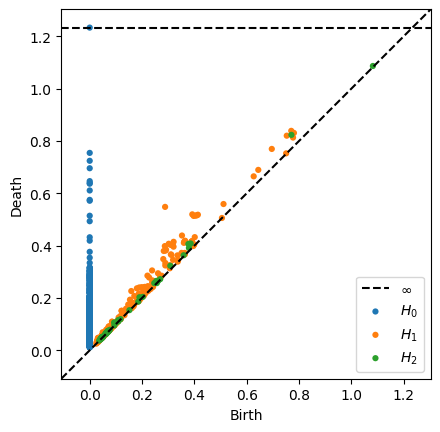

In [42]:
dgms = ripser(y_slug_embedded, maxdim=3)['dgms']
plot_diagrams(dgms, show=True)

In [43]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 876, 10)
y_slug_embedded.shape (876, 10)


In [44]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[9.30442609, 7.25567452, 4.90054526]])

In [136]:
embedding_dimension = 12
embedding_time_delay = 10
stride = 2

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(C22F046_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

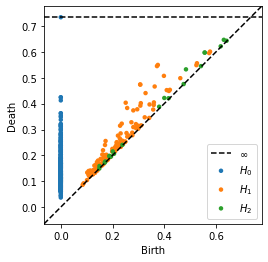

In [137]:
dgms = ripser(y_slug_embedded, maxdim=2)['dgms']
plot_diagrams(dgms, show=True)

In [138]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 413, 7)
y_slug_embedded.shape (413, 7)


In [139]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[8.56019349, 6.30274603, 3.45663852]])

In [49]:
embedding_dimension = 10
embedding_time_delay = 3
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(C22F046_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [51]:
embedding_dimension = 10
embedding_time_delay = 2
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(C22F046_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [52]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 439, 5)
y_slug_embedded.shape (439, 5)


In [53]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[8.24846436, 5.16503827, 2.91567409]])

In [165]:
period = 3
periodicSampler = Resampler(period=period)

C22F046_signal = C22F046.iloc[:, 1]
C22F046_time = C22F046.iloc[:, 0]

# throw away the first 100 points
C22F046_signal = C22F046_signal[100:]
C22F046_time = C22F046_time[100:]

X_sampled, y_sampled = periodicSampler.fit_transform_resample(C22F046_time, C22F046_signal)

fig = px.line(title='Trajectory of the Lorenz solution, projected along the z-axis and resampled every 10h')
#fig.add_scatter(y=C22F046_signal, name='C22F046_signal')
fig.add_scatter(y=y_sampled, name='y_sampled', mode='lines+markers')
fig.show()

In [166]:
TDAanalyze(y_sampled, 1)

length of signal to analyze 262
max time delay 131
max dim embedding 13
stride 1
Optimal embedding time delay based on mutual information: 4
Optimal embedding dimension based on false nearest neighbors: 9


array([[7.74894815, 5.86068559, 3.68907585]])

In [184]:
embedding_dimension = 9
embedding_time_delay = 2
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(y_sampled)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [185]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 254, 5)
y_slug_embedded.shape (254, 5)


In [186]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[ 7.77597423,  4.8602471 , -1.        ]])

In [107]:
TDAanalyze(y_sampled, 1)

length of signal to analyze 177
max time delay 88
max dim embedding 8
stride 1
Optimal embedding time delay based on mutual information: 2
Optimal embedding dimension based on false nearest neighbors: 4


array([[7.22952176, 4.57956027, 1.5007127 ]])

It is pretty clear that there is not a high persistency in these data, probably because the pattern is not really periodic (not quasi-periodic), rather is very chaotic. In the equations from Perea, it is assumed that the time serie could be expanded in Fourier series. Maybe, these data are not.... 

In [228]:
embedding_dimension = 9
embedding_time_delay = 2
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(y_sampled)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [229]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 254, 5)
y_slug_embedded.shape (254, 5)


In [405]:
MaxPers(PH_slug)

Max persistence class H_0: 0.3369234800338745 at point: [0.         0.33692348]
Max persistence class H_1: 0.15806288342849653 at point: [0.16836897 0.39190364]
Max persistence class H_2: 0.0 at point: [0. 0.]


In [621]:
def Silho():
    
    temp_list = []

    with open("list_of_csv.dat") as file:
        while (line := file.readline().rstrip()):
            temp_list.append(line)
    
    stride = 1
    PEntropy = []
    
    for filename in temp_list:
        
        print(filename)
        signal = pd.read_csv(filename)
        filename_no_extention = filename.replace('.csv','')
        
        slug_signal = []        
        slug_signal = signal.iloc[:, 1]

        optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        slug_signal, max_time_delay, max_embedding_dimension, stride=stride
        )

        print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
        print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
       
        embedding_dimension = optimal_embedding_dimension
        embedding_time_delay = optimal_time_delay
        stride = stride

        embedder = SingleTakensEmbedding(
            parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
            )

        y_signal_embedded = embedder.fit_transform(slug_signal)#

        pca = PCA(n_components=3)
        y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

        plot_point_cloud(y_signal_embedded_pca)

        homology_dimensions = (0, 1, 2)
        VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

        # the array need to be reshaped as the library expects many 2D arrays of dimensions 
        # n_windows x window_size

        y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)#

        PH_signal = VRP.fit_transform(y_signal_embedded_reshaped)
        #VRP.plot(PH_signal)
        np.savetxt(filename_no_extention + '.phg', PH_signal[0,:])
        
        PE_signal = PersistenceEntropy()
        features = PE_signal.fit_transform(PH_signal)
        PEntropy.append(features[0])
        
        SLH = Silhouette()
        slug_SLH = SLH.fit_transform(PH_signal)
        filename_silhouette = filename_no_extention + '.silh'
        np.savetxt(filename_silhouette, slug_SLH[0,:])
        np.save(filename_silhouette, slug_SLH)
        
        Betti = BettiCurve()
        slug_Betti = Betti.fit_transform(PH_signal)
        filename_betti = filename_no_extention + '.betti'
        np.savetxt(filename_betti, slug_Betti[0,:])
        
    np.savetxt('PersistentEntropy.dat',PEntropy)
        
    return

In [623]:
Silho()

C22F002.csv
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 8
C22F003.csv
Optimal embedding time delay based on mutual information: 14
Optimal embedding dimension based on false nearest neighbors: 8
C22F004.csv
Optimal embedding time delay based on mutual information: 15
Optimal embedding dimension based on false nearest neighbors: 5
C22F006.csv
Optimal embedding time delay based on mutual information: 14
Optimal embedding dimension based on false nearest neighbors: 8
C22F007.csv
Optimal embedding time delay based on mutual information: 12
Optimal embedding dimension based on false nearest neighbors: 12
C22F008.csv
Optimal embedding time delay based on mutual information: 9
Optimal embedding dimension based on false nearest neighbors: 8
C22F009.csv
Optimal embedding time delay based on mutual information: 7
Optimal embedding dimension based on false nearest neighbors: 5
C22F010.csv
Optimal embedding time delay b

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



C22F016.csv
Optimal embedding time delay based on mutual information: 14
Optimal embedding dimension based on false nearest neighbors: 9


/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



C22F017.csv
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 6


/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



C22F018.csv
Optimal embedding time delay based on mutual information: 13
Optimal embedding dimension based on false nearest neighbors: 5
C22F019.csv
Optimal embedding time delay based on mutual information: 14
Optimal embedding dimension based on false nearest neighbors: 4
C22F020.csv
Optimal embedding time delay based on mutual information: 10
Optimal embedding dimension based on false nearest neighbors: 11
C22F021.csv
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 10
C22F023.csv
Optimal embedding time delay based on mutual information: 12
Optimal embedding dimension based on false nearest neighbors: 4
C22F024.csv
Optimal embedding time delay based on mutual information: 12
Optimal embedding dimension based on false nearest neighbors: 6
C22F025.csv
Optimal embedding time delay based on mutual information: 12
Optimal embedding dimension based on false nearest neighbors: 8
C22F027.csv
Optimal embedding time dela

In [625]:
plot()

C22F002.silh C22F010.silh C22F019.silh C22F028.silh C22F036.silh C22F044.silh
C22F003.silh C22F012.silh C22F020.silh C22F029.silh C22F037.silh C22F045.silh
C22F004.silh C22F013.silh C22F021.silh C22F030.silh C22F038.silh C22F046.silh
C22F006.silh C22F014.silh C22F023.silh C22F032.silh C22F040.silh
C22F007.silh C22F016.silh C22F024.silh C22F033.silh C22F041.silh
C22F008.silh C22F017.silh C22F025.silh C22F034.silh C22F042.silh
C22F009.silh C22F018.silh C22F027.silh C22F035.silh C22F043.silh


In [626]:
!cat C22F041.silh

0.000000000000000000e+00 6.482114695539373250e-03 1.296422939107874824e-02 1.944634408661813363e-02 2.592845878215749300e-02 3.240500459380329240e-02 3.884201325538821914e-02 4.523285938522202815e-02 5.150232831815099860e-02 5.759916078456273764e-02 6.352420634693686785e-02 6.918755494299790032e-02 7.430222159011244665e-02 7.869345105508251947e-02 8.246278642577593854e-02 8.566992675277516900e-02 8.825466340988002978e-02 8.996487787481642628e-02 9.097688384076758894e-02 9.138269940891999288e-02 9.108125441519600296e-02 9.011596766295885963e-02 8.859822446839861476e-02 8.659801376811873674e-02 8.441491016730495733e-02 8.197763652984567384e-02 7.938652222728866115e-02 7.661626798572625241e-02 7.351073160528363848e-02 7.028953824661753058e-02 6.697225329118940140e-02 6.363049611206170186e-02 6.031566282098169141e-02 5.704204342870505817e-02 5.387076220034803936e-02 5.073575721735244098e-02 4.765483331394297639e-02 4.465365143683332899e-02 4.182581699382777185e-02 3.913893040279348839e-02 

In [627]:
!cat PersistentEntropy.dat

9.520767800938868319e+00 8.020613760030471440e+00 6.375592134167950675e+00
9.446380169531281012e+00 7.584020364414965520e+00 5.188334833394762313e+00
9.408478216800038041e+00 7.745088133509959505e+00 5.810316508799028945e+00
9.463036634623824384e+00 7.853871934584980785e+00 6.571338720341953987e+00
9.404609668825052893e+00 8.020992654960350521e+00 6.423280059207765902e+00
9.560446543818477139e+00 8.581205222831572499e+00 7.790526807980406865e+00
9.550961202941268269e+00 8.447067335890983131e+00 6.984746842254199173e+00
9.540048742552833971e+00 8.698773158730203292e+00 7.434309209671628338e+00
9.376932249270156561e+00 7.858060680637819928e+00 6.567156684795111055e+00
9.327712140717959954e+00 8.880878084357620494e+00 7.982544307234085146e+00
9.498362199511475978e+00 8.006305372247895846e+00 6.917223628484516773e+00
9.434629103638954462e+00 7.975399530223722167e+00 7.169083038997878354e+00
9.593750035243925112e+00 8.678388874677340326e+00 7.628221862695571787e+00
9.449048343328566801e+00 

In [10]:
def Compute_PH():
    
    temp_list = []

    with open("list_of_csv_tmp.dat") as file:
        while (line := file.readline().rstrip()):
            temp_list.append(line)
    
    stride = 1
    
    for filename in temp_list:
        
        signal = pd.read_csv(filename)
        filename_no_extention = filename.replace('.csv','')
        
        slug_signal = []        
        slug_signal = signal.iloc[:, 1]

        max_time_delay = 30 #int(len(signal)/2) 
        max_embedding_dimension = 28 #int(len(signal)/22)
        optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        slug_signal, max_time_delay, max_embedding_dimension, stride=stride
        )
  
        embedding_dimension = optimal_embedding_dimension
        embedding_time_delay = optimal_time_delay
        stride = stride

        embedder = SingleTakensEmbedding(
            parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
            )

        y_signal_embedded = embedder.fit_transform(slug_signal)
        filename_PH = filename_no_extention + '_PH'
        filename_PH_diag = filename_PH + '_diag'
        
        tmp_diag = ripser(y_signal_embedded, maxdim=2)['dgms']         
        np.save(filename_PH_diag, tmp_diag)
        print(filename_PH_diag,'dimensions', optimal_embedding_dimension, 'time delay', optimal_time_delay)

    return

In [11]:
Compute_PH()

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


C22F038_PH_diag dimensions 14 time delay 25
C22F040_PH_diag dimensions 6 time delay 25


/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [5]:
def Compute_distances():
    
    list_of_diags = []
    save_matrix = open("bottleneck_H1.dat", "w")
    
    with open("list_of_csv.dat") as file:
        while (line := file.readline().rstrip()):
            line_name = line + '_PH_diag.npy'
            list_of_diags.append(line_name)
    
    s = (len(list_of_diags), len(list_of_diags))
    bottleneck_matrix = np.zeros(s)
    i = 0
    j = 0
    
    for first_dgrm in list_of_diags:
        i += 1
        j = 0
        for second_dgrm in list_of_diags:
            j += 1
            if j > i :
                if first_dgrm != second_dgrm:
                    diag1 = np.load(first_dgrm,allow_pickle=True)
                    diag2 = np.load(second_dgrm,allow_pickle=True)
        
                    dmg1 = list(diag1.flatten())
                    dmg2 = list(diag2.flatten())

                    d_bottle = bottleneck(dmg1[1], dmg2[1], matching=False)
                    
                    print(i-1,j-1,d_bottle)
                    save_matrix.write(str(i-1) + ' ' + str(j-1) + ' ' + str(d_bottle)+ '\n')

                    bottleneck_matrix[i-1,j-1] = d_bottle
    
    for i in range(len(list_of_diags)):
        for j in range(len(list_of_diags)):
            if bottleneck_matrix[i,j] != 0:
                bottleneck_matrix[j,i] = bottleneck_matrix[i,j]
                
                
    save_matrix.close()            
    plt.imshow(bottleneck_matrix, interpolation='nearest', cmap=cm.viridis)
    plt.colorbar()
    plt.show()

0 1 0.07738938927650452
0 2 0.08303037285804749
0 3 0.10327593982219696
0 4 0.10327593982219696
0 5 0.08025050163269043
0 6 0.10327593982219696
0 7 0.10194683074951172
0 8 0.08535608649253845
0 9 0.10327593982219696
0 10 0.0672910213470459
0 11 0.11529672145843506
0 12 0.10327593982219696
0 13 0.0850822925567627
0 14 0.07735931873321533
0 15 0.0532536506652832
0 16 0.06112414598464966
0 17 0.11108270287513733
0 18 0.06743001937866211
0 19 0.08343136310577393
0 20 0.0643620491027832
0 21 0.08201152086257935
0 22 0.05164346098899841
0 23 0.08452019095420837
0 24 0.08994641900062561
0 25 0.09602326154708862
0 26 0.10327593982219696
0 27 0.10327593982219696
0 28 0.10847786068916321
0 29 0.06925681233406067
0 30 0.16050368547439575
0 31 0.07712817192077637
0 32 0.07029280066490173
0 33 0.056647032499313354
0 34 0.08691534399986267
0 35 0.07836779952049255
0 36 0.08048337697982788
0 37 0.08739009499549866
1 2 0.08349159359931946
1 3 0.0811198353767395
1 4 0.0935785174369812
1 5 0.05728363990

10 17 0.11108270287513733
10 18 0.07131388783454895
10 19 0.08533990383148193
10 20 0.06903305649757385
10 21 0.06904619932174683
10 22 0.05786365270614624
10 23 0.07405519485473633
10 24 0.08904844522476196
10 25 0.08589974045753479
10 26 0.1153704971075058
10 27 0.09244132041931152
10 28 0.10847786068916321
10 29 0.06756088137626648
10 30 0.16050368547439575
10 31 0.09024274349212646
10 32 0.08574628829956055
10 33 0.047098755836486816
10 34 0.08948582410812378
10 35 0.09317910671234131
10 36 0.06512418389320374
10 37 0.0795905590057373
11 12 0.11656731367111206
11 13 0.07259204983711243
11 14 0.11529672145843506
11 15 0.11529672145843506
11 16 0.11529672145843506
11 17 0.10327231884002686
11 18 0.09377038478851318
11 19 0.11529672145843506
11 20 0.10853958129882812
11 21 0.11493414640426636
11 22 0.11529672145843506
11 23 0.11529672145843506
11 24 0.11529672145843506
11 25 0.11529672145843506
11 26 0.11656731367111206
11 27 0.11656731367111206
11 28 0.10847786068916321
11 29 0.11274

26 37 0.12600107491016388
27 28 0.10847786068916321
27 29 0.06607222557067871
27 30 0.16050368547439575
27 31 0.11123189330101013
27 32 0.08633983135223389
27 33 0.07025408744812012
27 34 0.062172695994377136
27 35 0.05783545970916748
27 36 0.05197449028491974
27 37 0.114752858877182
28 29 0.10096821188926697
28 30 0.10440996289253235
28 31 0.10847786068916321
28 32 0.10847786068916321
28 33 0.10847786068916321
28 34 0.10847786068916321
28 35 0.10847786068916321
28 36 0.10847786068916321
28 37 0.10847786068916321
29 30 0.13088294863700867
29 31 0.07301956415176392
29 32 0.0734434723854065
29 33 0.0640193521976471
29 34 0.0640193521976471
29 35 0.0640193521976471
29 36 0.0640193521976471
29 37 0.08928510546684265
30 31 0.16050368547439575
30 32 0.16050368547439575
30 33 0.16050368547439575
30 34 0.16050368547439575
30 35 0.16050368547439575
30 36 0.16050368547439575
30 37 0.16050368547439575
31 32 0.05704253911972046
31 33 0.07431304454803467
31 34 0.08956688642501831
31 35 0.0867906063

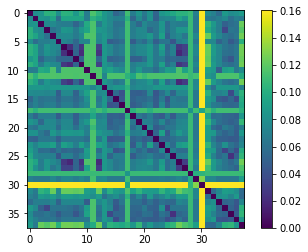

In [6]:
Compute_distances()

Ideally, I should run a Marchenko-Pastur test to make sure this is not just noise.... 

Clerarly there is something weird happening in the timeseries nr.30, i.e. C22F038. 

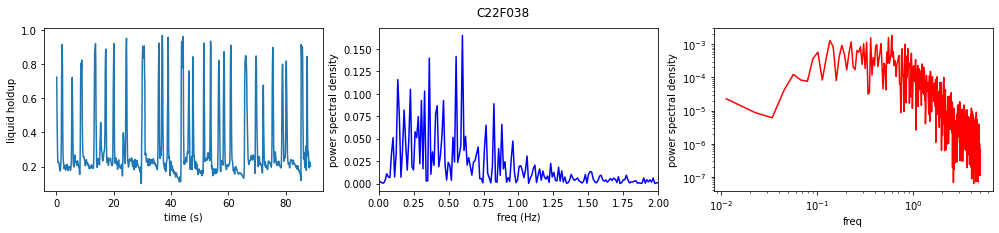

In [18]:
C22F038 = pd.read_csv('C22F038.csv')

fig_C22F038, data = plt.subplots(1, 3, figsize=(17, 3))

fig_C22F038.suptitle('C22F038')
data[0].set_xlabel('time (s)')
data[0].set_ylabel('liquid holdup')
data[1].set_xlabel('freq (Hz)')
data[1].set_ylabel('power spectral density')
data[1].set_xlim([0,2.])
data[2].set_xlabel('freq')
data[2].set_ylabel('power spectral density')

freqs, ps, psd, inv = spectrum1(C22F038[C22F038.columns[1]], dt=0.1)

data[0].plot(C22F038[C22F038.columns[0]],C22F038[C22F038.columns[1]])
data[1].plot(freqs,psd,'b')
data[2].loglog(freqs,ps,'r')

In [236]:
C22F038_signal = C22F038.iloc[:, 1]

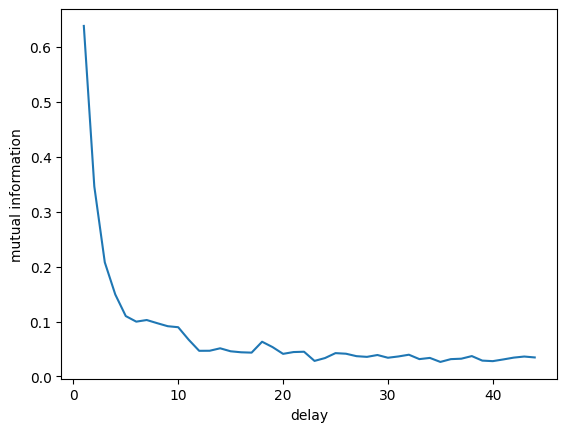

In [237]:
plot_optimal_delay(C22F038_signal)

In [238]:
max_time_delay = 30
max_embedding_dimension = 20
stride =1 

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        signal, max_time_delay, max_embedding_dimension, stride=stride
        )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
        
embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay
stride = stride

embedder = SingleTakensEmbedding(    
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
    )

y_signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

plot_point_cloud(y_signal_embedded_pca)

homology_dimensions = (0, 1, 2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

    # the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)

PH_signal = VRP.fit_transform(y_signal_embedded_reshaped)
VRP.plot(PH_signal)

Optimal embedding time delay based on mutual information: 25
Optimal embedding dimension based on false nearest neighbors: 14


In [20]:
plot_point_cloud(y_signal_embedded_pca)

In [239]:
signal = C22F038_signal

max_time_delay = 30
max_embedding_dimension = 20
stride =2 

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        signal, max_time_delay, max_embedding_dimension, stride=stride
        )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
        
embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay
stride = stride

embedder = SingleTakensEmbedding(    
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
    )

y_signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

plot_point_cloud(y_signal_embedded_pca)

homology_dimensions = (0, 1, 2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

    # the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)

PH_signal = VRP.fit_transform(y_signal_embedded_reshaped)
VRP.plot(PH_signal)

Optimal embedding time delay based on mutual information: 25
Optimal embedding dimension based on false nearest neighbors: 7


Let's try to kill the frequencies >1 Hz, so to simplify the shape of the peaks. 

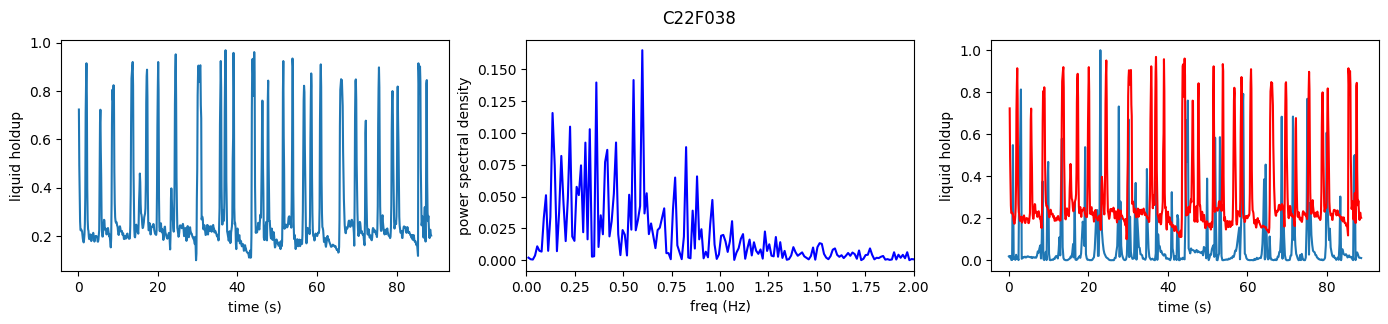

In [254]:
C22F038 = pd.read_csv('C22F038.csv')

fig_C22F038, data = plt.subplots(1, 3, figsize=(17, 3))

fig_C22F038.suptitle('C22F038')
data[0].set_xlabel('time (s)')
data[0].set_ylabel('liquid holdup')
data[1].set_xlabel('freq (Hz)')
data[1].set_ylabel('power spectral density')
data[1].set_xlim([0,2.])
data[2].set_xlabel('time (s)')
data[2].set_ylabel('liquid holdup')

freqs, ps, psd, inv = spectrum1(C22F038[C22F038.columns[1]], dt=0.1)


data[0].plot(C22F038[C22F038.columns[0]],C22F038[C22F038.columns[1]])
data[1].plot(freqs,psd,'b')
data[2].plot(np.linspace(0, np.amax(C22F038[C22F038.columns[0]]), num=len(inv)), (np.real(inv)**2)/np.max(np.real(inv)**2))
#data[2].plot(C22F038[C22F038.columns[0]],C22F038[C22F038.columns[1]], 'r')


peak_freq= 0.5988700564971752


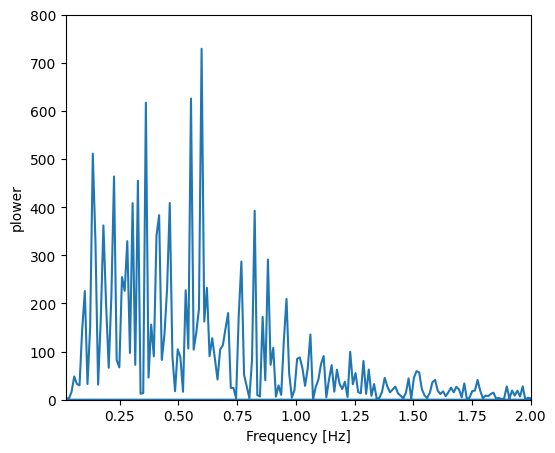

In [286]:
# The FFT of the signal
from scipy import fftpack

sig = np.asarray(C22F038[C22F038.columns[1]])
sig_fft = fftpack.fft(sig)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)**2

# The corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=0.1)


#sig_inv = fftpack.ifft(sig_fft)
#high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
#filtered_sig = fftpack.ifft(high_freq_fft)


# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
#plt.plot(sample_freq, sig_inv**2, 'r')
#plt.plot(sample_freq, sig**2, 'g')

plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')
plt.xlim([0.02,2.])
plt.ylim([0,800.])

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
print('peak_freq=',peak_freq)


# Check that it does indeed correspond to the frequency that we generate
# the signal with
#np.allclose(peak_freq, 1./period)

# An inner plot to show the peak frequency
#axes = plt.axes([0.55, 0.3, 0.3, 0.5])
#plt.title('Peak frequency')
#plt.plot(freqs[:8], power[:8])
#plt.setp(axes, yticks=[])

# scipy.signal.find_peaks_cwt can also be used for more advanced
# peak detection

In [8]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

In [28]:
xi, yi, zi = sample_spherical(200)

In [64]:
y_signal_embedded_reshaped
type(y_signal_embedded_reshaped)
y_signal_embedded_reshaped.shape

(1, 701, 9)

In [60]:
sphere = []
for i in range(len(xi)):
    vec = [xi[i], yi[i], zi[i]]
    sphere.append(vec)
    
sphere = np.array(sphere)
sphere = sphere.reshape(1, *sphere.shape)

In [61]:
sphere.shape

(1, 200, 3)

In [65]:
VRP.fit_transform_plot(sphere)

array([[[0.        , 0.00593857, 0.        ],
        [0.        , 0.00913097, 0.        ],
        [0.        , 0.01068146, 0.        ],
        [0.        , 0.01714592, 0.        ],
        [0.        , 0.02871926, 0.        ],
        [0.        , 0.02914548, 0.        ],
        [0.        , 0.03364846, 0.        ],
        [0.        , 0.03574726, 0.        ],
        [0.        , 0.04594796, 0.        ],
        [0.        , 0.04760765, 0.        ],
        [0.        , 0.04996919, 0.        ],
        [0.        , 0.05118166, 0.        ],
        [0.        , 0.05679219, 0.        ],
        [0.        , 0.05915442, 0.        ],
        [0.        , 0.06139376, 0.        ],
        [0.        , 0.06376623, 0.        ],
        [0.        , 0.0645887 , 0.        ],
        [0.        , 0.06609961, 0.        ],
        [0.        , 0.06663401, 0.        ],
        [0.        , 0.06744471, 0.        ],
        [0.        , 0.07111538, 0.        ],
        [0.        , 0.07348518, 0

In [233]:
# fourier series defintions
tau = 0.45
def fourier16(x, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16):
    return (a1 * np.cos(1 * np.pi / tau * x) + 
           a2 * np.cos(2 * np.pi / tau * x) + 
           a3 * np.cos(3 * np.pi / tau * x) + 
           a4 * np.cos(4 * np.pi / tau * x) + 
           a5 * np.cos(5 * np.pi / tau * x) + 
           a6 * np.cos(6 * np.pi / tau * x) + 
           a7 * np.cos(7 * np.pi / tau * x) + 
           a8 * np.cos(8 * np.pi / tau * x) +
           a9 * np.cos(9 * np.pi / tau * x) + 
           a10 * np.cos(10 * np.pi / tau * x) + 
           a11 * np.cos(11 * np.pi / tau * x) + 
           a12 * np.cos(12 * np.pi / tau * x) + 
           a13 * np.cos(13 * np.pi / tau * x) + 
           a14 * np.cos(14 * np.pi / tau * x) + 
           a15 * np.cos(15 * np.pi / tau * x) + 
           a16 * np.cos(16 * np.pi / tau * x)
           )

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


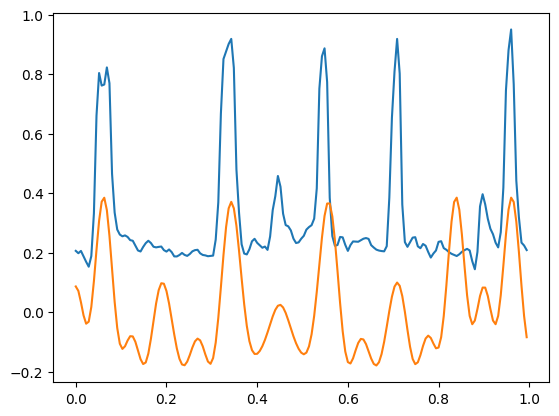

In [234]:
from scipy.optimize import curve_fit

z_list = []
Ua_list = signal[75:250].tolist()

for i in range(len(Ua_list)):
    z_list.append(i/len(Ua_list))

    
z = np.asarray(z_list)
Ua = np.asarray(Ua_list)
print(type(Ua), type(z))

# plot data
fig = plt.figure()
ax1 = fig.add_subplot(111)
p1, = plt.plot(z,Ua)

# fits
popt, pcov = curve_fit(fourier16, z, Ua)

# further plots
Ua_fit8 = fourier16(z,*popt)
p2, = plt.plot(z,Ua_fit8)

plt.show()

In [210]:
pp = signal.tolist()
pp

[0.7230055380930998,
 0.4930100284388564,
 0.3762909744050292,
 0.2607394102679237,
 0.2249962580452023,
 0.2233797335728181,
 0.2267923963478519,
 0.2223319862296064,
 0.2188594521778175,
 0.2015566531956295,
 0.1874869031582093,
 0.1795539589881754,
 0.1737165095045654,
 0.1857207004939379,
 0.2068851968268221,
 0.2497530309833865,
 0.3591378536147281,
 0.71001347103727,
 0.8299655740158662,
 0.9141445891333634,
 0.769525520131717,
 0.3980841191438404,
 0.2681035773087868,
 0.2287382128423885,
 0.220416105373447,
 0.1958688819039067,
 0.1870079329441699,
 0.1941625505163895,
 0.2005089058524173,
 0.2068253255500673,
 0.198772638826523,
 0.1791947313276454,
 0.1831462355934741,
 0.2028738212842392,
 0.2023349797934436,
 0.2085615925759613,
 0.2133812303547375,
 0.2028738212842382,
 0.1871875467744341,
 0.1770393653644658,
 0.1831761712318514,
 0.1953300404131116,
 0.2001197425535094,
 0.1964975303098335,
 0.1973656638227808,
 0.1985930249962582,
 0.1962281095644361,
 0.177338721748241